In [1]:
from generate_data import Data
from evaluate import *
from models import *

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [4]:
%%time
data = Data(layer_size=16)

c:\Users\juand\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


Wall time: 1.07 s


In [5]:
%%time
train, val, test = data.get_splits(['skip'], [4])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 993 train | 595 val | 2381 test
Wall time: 431 ms


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[[',..._.._,.___._.', 'w,,_,.,_,__.._.,', 'cr__,._,._,._,__', False],
 [',.._.._,_...,.,_', 'w.__,,_,,_,__..,', '..,_cr_.,.,_.___', False],
 ['..,._,.__.,__,,_', 'w,,_,..__,_,_,..', '_,._,__.cr._,___', False],
 ['_,,,,,._.,..,___', 'w.,_.,_,__,.,__,', '.,..,.__...,cr..', False],
 ['_.,,____._.,_,._', ',w._...._.,,_,_.', '_cr____,._.,,,_.', False],
 [',__,.__._,.__,..', '.w,,.,.,.,._,_,.', ',..._cr,,.,..,_,', False],
 ['_,_,..,,_,___...', '.w_.._.,,.,,..,_', '_,..__._,cr.___,', False],
 ['_.,_,.,.,._,__._', '_w,,,,,_.,..,,,,', '.,,,,__..,_,_cr,', False],
 [',,_...___.,,,,_.', '..w,,,,,_.._.,_.', ',_cr.,__,._,_,._', False],
 ['._,_,_...__,,,_,', '..w,._.___._,..,', ',__.,.cr,_.,,._.', False],
 [',_.._._,,..,.,.,', ',_w,,,..___,__.,', '____.,,,_.cr___,', False],
 ['__.,__,_.._,,.__', '..w.,.,._,._,,_,', '_,.,,_.,,.,_,,cr', False],
 [',.,.,,._,_,,,.,_', '__.w_,.,_,.,...,', '.,.cr_..,,.._._,', False],
 ['..,_..__,.,_....', ',_.w,,,.__,.__.,', '_,....,cr.,,._..', False],
 ['.,.,..,._._..__.'

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 56 | F2-uw 56 | F2-w 60 | F2-noop 63 | 
F3 cr:    F2-wu 57 | F2-uw 56 | F2-w 60 | F2-noop 64 | 
F3 r:    F2-wu 60 | F2-uw 60 | F2-w 64 | F2-noop 68 | 
F3 noop:    F2-wu 64 | F2-uw 64 | F2-w 68 | F2-noop 73 | 

Positive samples count: 431
Total samples count: 993
Positive class ratio: 0.4340382678751259


#### Peek at test data

In [8]:
test_original[:15]

[['_,,,.,,,,,,,.,,.', '.,___,,,_,..___,', ',._.,..._...cr..', False],
 ['_.._,,.,,,,,_...', ',,,____.,_,,.uw_', '__.._._,,____.__', False],
 [',__,.__.,,_,,._,', '._w,,_._.,.___.,', ',,_,_.,___,,_._.', False],
 ['.,.,_,__.,_,_.._', '.___,...,.,,_.,,', '____._.,dr.,.,._', True],
 ['._._.,,..,,_,..,', ',.._.__.,_,.__.w', '__,,.r,.,,__..,,', True],
 [',_...___.._,,,__', '.._uw_,_._,_.,_,', '_..._.,_....___,', False],
 ['.._,__,,_,,,,__,', '__,,,.___.,.,.._', '___,_.r,_,.,,__,', True],
 ['_,_.,__,_,_,__,.', '.._._.,,._.,.w..', '.,_..,,_,..._._,', False],
 ['___._,_,__..,._.', ',._,_.,,..wu..,.', '_.,_.,,,.r..,___', True],
 ['_.,._,_..__,....', '_.,.,.._.,__._wu', '_,___.__._..____', False],
 [',,.,_,__.,.__.,_', '...,__.,.__._..,', '_,_....,,.cr,__,', False],
 ['._..__,,,,,.,,_.', '.._._,.,__.,__,_', ',,___..,dr__..__', True],
 [',____.,,.,.._,._', '___uw,_,,,_.,.__', '__,dr_.._._,,._.', True],
 ['._._.._.__,..,,,', '_,_,_.,.__.w___.', '_,_,dr,__._.....', True],
 [',,_._,._,.._._,,', '.w_.

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 136 | F2-uw 138 | F2-w 151 | F2-noop 153 | 
F3 cr:    F2-wu 129 | F2-uw 146 | F2-w 150 | F2-noop 149 | 
F3 r:    F2-wu 136 | F2-uw 149 | F2-w 149 | F2-noop 166 | 
F3 noop:    F2-wu 148 | F2-uw 152 | F2-w 159 | F2-noop 170 | 

Positive samples count: 1042
Total samples count: 2381
Positive class ratio: 0.4376312473750525


#### Peek at val data

In [10]:
val_original[:15]

[['__._____...._,,_', ',__wu,.,__,,.,..', 'cr_,,.__.,.__,,_', False],
 [',,_,.,_.,,,._,_.', ',_,..,.,,.,_,__.', 'cr_,.__,,...,___', False],
 ['__._._.__._,._,,', ',_,__,_,,_.._,,,', ',,,.,._,__,._cr.', False],
 ['_._,_._.,,..._,_', '...,,,,,_,,,_.,w', '__,,,.,,,_._.r_,', True],
 ['....,._,,,_.,.__', '._,__..,,_.,,._.', '.,.._._,__r.__.,', True],
 [',___,_.._,.._,..', ',...._,w.,,.,,._', '_.._.___,__.,_r.', True],
 [',.,_,..,.__.__.,', ',,,,,,,uw_.,_...', ',.._..,,_.,,r...', True],
 ['..__,.,.__.,_,_,', 'wu_,,.._,_.___,_', '.,,____.,..,,_dr', False],
 ['_._._..,._,.,..,', '.._.._wu..__.__.', '__.,__,,,r_____,', True],
 ['__.._,_,__,.,__,', ',.,,,.,.._uw_._,', '.,,..__._,_r.__,', True],
 [',_,._.,.__.,,,_.', '_,.uw,_._....._,', '__._..,___,,,.,,', False],
 ['.,..,._,,,,.,_,.', ',..,wu.__,._._._', '___.r.__,,.,_,..', True],
 ['.._,_,_,.,._,.__', ',.._.,,.,.,._,,w', '..,__,cr.,,___,,', False],
 ['_,,._...,_,,.,_.', '_,,,,_wu.,_,..__', '.._,_.,....__cr_', False],
 ['.__,.._.,.,,_,_.', ',.._

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 33 | F2-uw 31 | F2-w 29 | F2-noop 39 | 
F3 cr:    F2-wu 39 | F2-uw 23 | F2-w 30 | F2-noop 42 | 
F3 r:    F2-wu 44 | F2-uw 31 | F2-w 43 | F2-noop 38 | 
F3 noop:    F2-wu 43 | F2-uw 39 | F2-w 45 | F2-noop 46 | 

Positive samples count: 255
Total samples count: 595
Positive class ratio: 0.42857142857142855


#### Send label arrays to device

In [12]:
y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
y_test = torch.from_numpy(y_test.astype(float)).float().to(device)

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([993, 128])

#### Get data in convolutional format, send to device

In [15]:
x_train_cnn = data.to_conv_format(x_train)
x_val_cnn = data.to_conv_format(x_val)
x_test_cnn = data.to_conv_format(x_test)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([993, 128])

#### Get data in LSTM format, send to device

In [17]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [18]:
x_train_lstm[0].shape

torch.Size([993, 16, 8])

### Define training parameters

In [19]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "skip_4"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    wrong_preds = []
    best_accuracy = 0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_{experiment_name}')    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_{experiment_name}'))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original))
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1s.append(get_f1(precisions[-1], recalls[-1]))
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_{experiment_name}')    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | Current model test accuracy:", accuracies[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test precision:", precisions[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test recall:", recalls[-1]['Overall'])
        print(i + 1, "/", num_experiments, "models trained | Current model test f1:", f1s[-1]['Overall'])
    return accuracies, precisions, recalls, f1s, wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [21]:
%%time
cnn_accuracies, cnn_precisions, cnn_recalls, cnn_f1s, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_18200\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.994960100797984
1 / 20 models trained | Current model test precision: 1.0
1 / 20 models trained | Current model test recall: 0.9884836852207294
1 / 20 models trained | Current model test f1: 0.9942084942084941
2 / 20 models trained | Current model test accuracy: 0.9941201175976481
2 / 20 models trained | Current model test precision: 1.0
2 / 20 models trained | Current model test recall: 0.9865642994241842
2 / 20 models trained | Current model test f1: 0.9932367149758454
3 / 20 models trained | Current model test accuracy: 0.994960100797984
3 / 20 models trained | Current model test precision: 1.0
3 / 20 models trained | Current model test recall: 0.9884836852207294
3 / 20 models trained | Current model test f1: 0.9942084942084941
4 / 20 models trained | Current model test accuracy: 0.9886602267954641
4 / 20 models trained | Current model test precision: 0.9970617042115573
4 / 20 models trained | Current model test recall: 0.976967

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recalls, lstm_f1s, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_18200\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 1.0
1 / 20 models trained | Current model test precision: 1.0
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 1.0
2 / 20 models trained | Current model test accuracy: 0.9416211675766485
2 / 20 models trained | Current model test precision: 0.8875536480686695
2 / 20 models trained | Current model test recall: 0.9923224568138196
2 / 20 models trained | Current model test f1: 0.9370185772541911
3 / 20 models trained | Current model test accuracy: 0.999580008399832
3 / 20 models trained | Current model test precision: 1.0
3 / 20 models trained | Current model test recall: 0.9990403071017274
3 / 20 models trained | Current model test f1: 0.99951992318771
4 / 20 models trained | Current model test accuracy: 0.999580008399832
4 / 20 models trained | Current model test precision: 1.0
4 / 20 models trained | Current model test recall: 0.9990403071017274
4 / 20 models trained | Current mode

In [23]:
%%time
deepset_accuracies, deepset_precisions, deepset_recalls, deepset_f1s, deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_18200\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.8362032759344813
1 / 20 models trained | Current model test precision: 0.8528138528138528
1 / 20 models trained | Current model test recall: 0.7562380038387716
1 / 20 models trained | Current model test f1: 0.8016276703967448
2 / 20 models trained | Current model test accuracy: 0.8433431331373372
2 / 20 models trained | Current model test precision: 0.86084142394822
2 / 20 models trained | Current model test recall: 0.7658349328214972
2 / 20 models trained | Current model test f1: 0.8105637379380396
3 / 20 models trained | Current model test accuracy: 0.8299034019319613
3 / 20 models trained | Current model test precision: 0.8598870056497175
3 / 20 models trained | Current model test recall: 0.7303262955854126
3 / 20 models trained | Current model test f1: 0.7898287493513233
4 / 20 models trained | Current model test accuracy: 0.8320033599328014
4 / 20 models trained | Current model test precision: 0.8550884955752213
4 / 20 models 

In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recalls, deepsetv2_f1s, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_18200\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.4376312473750525
1 / 20 models trained | Current model test precision: 0.4376312473750525
1 / 20 models trained | Current model test recall: 1.0
1 / 20 models trained | Current model test f1: 0.6088226701723634
2 / 20 models trained | Current model test accuracy: 0.4376312473750525
2 / 20 models trained | Current model test precision: 0.4376312473750525
2 / 20 models trained | Current model test recall: 1.0
2 / 20 models trained | Current model test f1: 0.6088226701723634
3 / 20 models trained | Current model test accuracy: 0.4376312473750525
3 / 20 models trained | Current model test precision: 0.4376312473750525
3 / 20 models trained | Current model test recall: 1.0
3 / 20 models trained | Current model test f1: 0.6088226701723634
4 / 20 models trained | Current model test accuracy: 0.4376312473750525
4 / 20 models trained | Current model test precision: 0.4376312473750525
4 / 20 models trained | Current model test recall: 1.0
4 

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recalls, feedforward_f1s, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

C:\Users\juand\AppData\Local\Temp\ipykernel_18200\3365763532.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./{model_name}_model_TEM

1 / 20 models trained | Current model test accuracy: 0.8416631667366653
1 / 20 models trained | Current model test precision: 0.8657865786578658
1 / 20 models trained | Current model test recall: 0.755278310940499
1 / 20 models trained | Current model test f1: 0.8067657611481291
2 / 20 models trained | Current model test accuracy: 0.8399832003359933
2 / 20 models trained | Current model test precision: 0.8308308308308309
2 / 20 models trained | Current model test recall: 0.7965451055662188
2 / 20 models trained | Current model test f1: 0.8133268005879472
3 / 20 models trained | Current model test accuracy: 0.8374632507349853
3 / 20 models trained | Current model test precision: 0.7985414767547858
3 / 20 models trained | Current model test recall: 0.8406909788867563
3 / 20 models trained | Current model test f1: 0.8190743338008415
4 / 20 models trained | Current model test accuracy: 0.8420831583368332
4 / 20 models trained | Current model test precision: 0.8708240534521158
4 / 20 models

# Evaluation

### Get best 50% performing models

In [26]:
top_half = int(num_experiments / 2)
best_cnn_accs = filter_top_k_accuracies(cnn_accuracies, top_half)
best_lstm_accs = filter_top_k_accuracies(lstm_accuracies, top_half)
best_deepset_accs = filter_top_k_accuracies(deepset_accuracies, top_half)
best_deepsetv2_accs = filter_top_k_accuracies(deepsetv2_accuracies, top_half)
best_feedforward_accs = filter_top_k_accuracies(feedforward_accuracies, top_half)

## Accuracy breakdown by cases for all the models

In [27]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [28]:
get_stats_df(all_accuracies, model_names, test_original)

,Overall,cr_noop,cr_uw,cr_w,cr_wu,dr_noop,dr_uw,dr_w,dr_wu,noop_noop,noop_uw,noop_w,noop_wu,r_noop,r_uw,r_w,r_wu
CNN,98.9%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.9%,99.8%,81.9%
LSTM,99.6%,100.0%,100.0%,100.0%,100.0%,99.9%,99.6%,99.8%,94.6%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,99.8%
DeepSet(like in paper),83.5%,99.7%,99.2%,99.4%,99.9%,92.4%,89.5%,91.7%,10.7%,98.8%,98.3%,98.9%,99.4%,62.3%,65.3%,61.4%,62.7%
DeepSet(sum at start),43.8%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,100.0%,100.0%,100.0%
Feedforward,83.8%,99.4%,99.1%,99.1%,99.5%,94.4%,89.8%,93.0%,11.2%,97.8%,98.0%,97.7%,98.6%,64.1%,66.4%,63.2%,62.2%
Sample count,2381,149,146,150,129,153,138,151,136,170,152,159,148,166,149,149,136


## Accuracy breakdown by cases for top 50% of models

In [29]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['dr', 'r', 'cr', 'noop']

In [30]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN,99.4%,100.0%,100.0%,100.0%,97.8%
LSTM,100.0%,100.0%,100.0%,100.0%,100.0%
DeepSet(like in paper),84.2%,99.5%,73.6%,98.5%,64.7%
DeepSet(sum at start),43.8%,0.0%,76.5%,0.0%,100.0%
Feedforward,84.2%,99.4%,74.2%,97.7%,65.1%
Sample count,2381,574,578,629,600


In [31]:
best_accuracies = [best_cnn_accs, best_lstm_accs, best_deepset_accs, best_deepsetv2_accs, best_feedforward_accs]
model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']
collapsed_cases = ['r', 'cr', 'noop']

In [32]:
get_stats_df(best_accuracies, model_names, test_original, collapsed_cases)

,Overall,dr_noop,dr_uw,dr_w,dr_wu,f3_cr,f3_noop,f3_r
CNN,99.4%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,97.8%
LSTM,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%
DeepSet(like in paper),84.2%,95.6%,91.5%,93.6%,8.5%,99.5%,98.5%,64.7%
DeepSet(sum at start),43.8%,100.0%,100.0%,100.0%,0.0%,0.0%,0.0%,100.0%
Feedforward,84.2%,95.4%,91.8%,94.0%,10.7%,99.4%,97.7%,65.1%
Sample count,2381,153,138,151,136,574,629,600


## Accuracies per CNN model

In [33]:
get_stats_per_model(cnn_accuracies, ['CNN #' + str(i) for i in range(len(cnn_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
CNN #0,99.5%,100.0%,100.0%,100.0%,98.0%
CNN #1,99.4%,100.0%,100.0%,100.0%,97.7%
CNN #2,99.5%,100.0%,100.0%,100.0%,98.0%
CNN #3,98.9%,100.0%,99.5%,100.0%,96.0%
CNN #4,99.9%,100.0%,100.0%,100.0%,99.7%
CNN #5,98.0%,100.0%,96.0%,100.0%,96.0%
CNN #6,98.9%,100.0%,99.8%,100.0%,95.8%
CNN #7,97.7%,100.0%,100.0%,100.0%,91.0%
CNN #8,99.5%,100.0%,100.0%,100.0%,98.2%
CNN #9,97.6%,100.0%,100.0%,100.0%,90.7%


## Accuracies per LSTM model

In [34]:
get_stats_per_model(lstm_accuracies, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
LSTM #0,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #1,94.2%,100.0%,76.0%,100.0%,100.0%
LSTM #2,100.0%,100.0%,100.0%,100.0%,99.8%
LSTM #3,100.0%,100.0%,100.0%,100.0%,99.8%
LSTM #4,100.0%,100.0%,100.0%,100.0%,100.0%
LSTM #5,99.9%,100.0%,99.7%,100.0%,99.8%
LSTM #6,99.5%,100.0%,97.9%,100.0%,100.0%
LSTM #7,99.9%,100.0%,99.5%,100.0%,100.0%
LSTM #8,99.8%,100.0%,99.3%,100.0%,100.0%
LSTM #9,100.0%,100.0%,99.8%,100.0%,100.0%


## Accuracies per DeepSets V1 model

In [35]:
get_stats_per_model(deepset_accuracies, ['DeepSet(like in paper) #' + str(i) for i in range(len(deepset_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(like in paper) #0,83.6%,99.7%,72.7%,98.6%,63.2%
DeepSet(like in paper) #1,84.3%,99.8%,73.5%,99.0%,64.5%
DeepSet(like in paper) #2,83.0%,100.0%,70.9%,99.0%,61.5%
DeepSet(like in paper) #3,83.2%,99.8%,69.4%,98.6%,64.5%
DeepSet(like in paper) #4,84.7%,99.5%,74.9%,95.5%,68.5%
DeepSet(like in paper) #5,84.5%,99.1%,75.1%,97.8%,65.7%
DeepSet(like in paper) #6,82.4%,99.3%,68.5%,99.2%,62.0%
DeepSet(like in paper) #7,82.6%,99.5%,71.6%,99.4%,59.3%
DeepSet(like in paper) #8,81.8%,98.8%,69.9%,99.5%,58.5%
DeepSet(like in paper) #9,82.6%,99.3%,73.2%,97.9%,59.5%


## Accuracies per DeepSets V2 model

In [36]:
get_stats_per_model(deepsetv2_accuracies, ['DeepSet(sum at start) #' + str(i) for i in range(len(deepsetv2_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
DeepSet(sum at start) #0,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #1,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #2,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #3,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #4,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #5,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #6,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #7,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #8,43.8%,0.0%,76.5%,0.0%,100.0%
DeepSet(sum at start) #9,43.8%,0.0%,76.5%,0.0%,100.0%


## Accuracies per FeedForward model

In [37]:
get_stats_per_model(feedforward_accuracies, ['Feedforward #' + str(i) for i in range(len(feedforward_accuracies))], test_original, ['cr', 'dr', 'noop', 'r'])

,Overall,f3_cr,f3_dr,f3_noop,f3_r
Feedforward #0,84.2%,99.7%,73.9%,99.5%,63.2%
Feedforward #1,84.0%,99.0%,75.1%,94.0%,67.8%
Feedforward #2,83.7%,95.1%,76.1%,90.1%,73.5%
Feedforward #3,84.2%,99.7%,74.7%,98.7%,63.3%
Feedforward #4,83.4%,99.8%,71.5%,98.6%,63.2%
Feedforward #5,84.3%,100.0%,75.6%,100.0%,61.3%
Feedforward #6,82.7%,100.0%,70.6%,99.4%,60.2%
Feedforward #7,83.3%,99.8%,71.3%,99.2%,62.3%
Feedforward #8,83.9%,99.8%,71.5%,99.8%,64.0%
Feedforward #9,83.2%,98.4%,73.4%,99.5%,61.2%


# Training evolution

### CNN

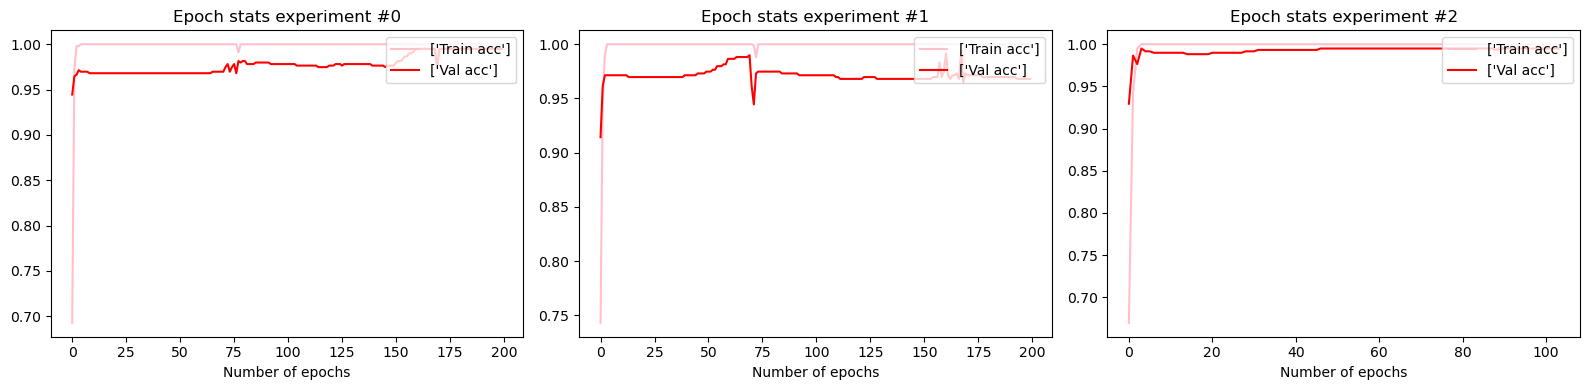

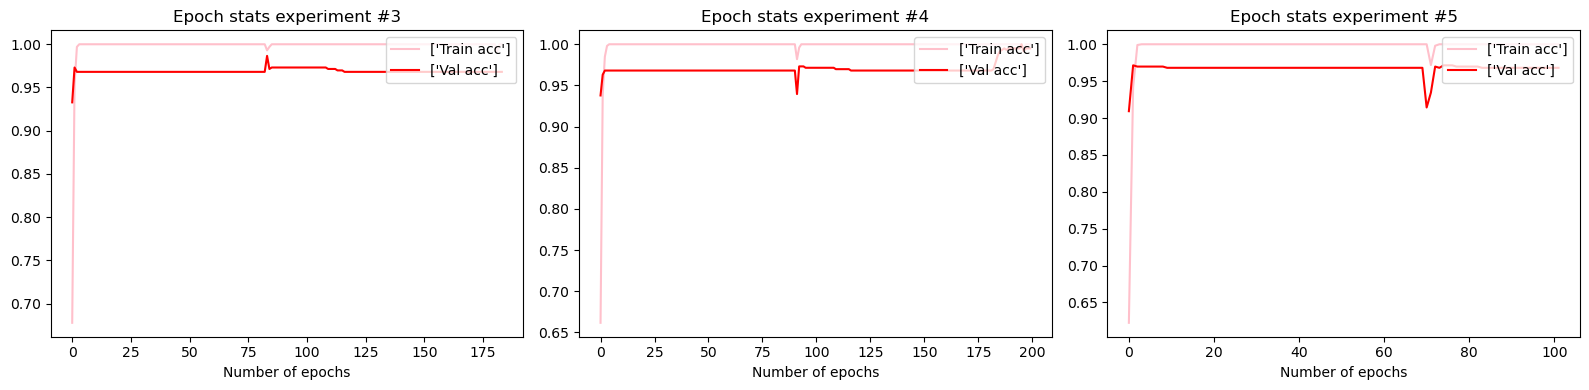

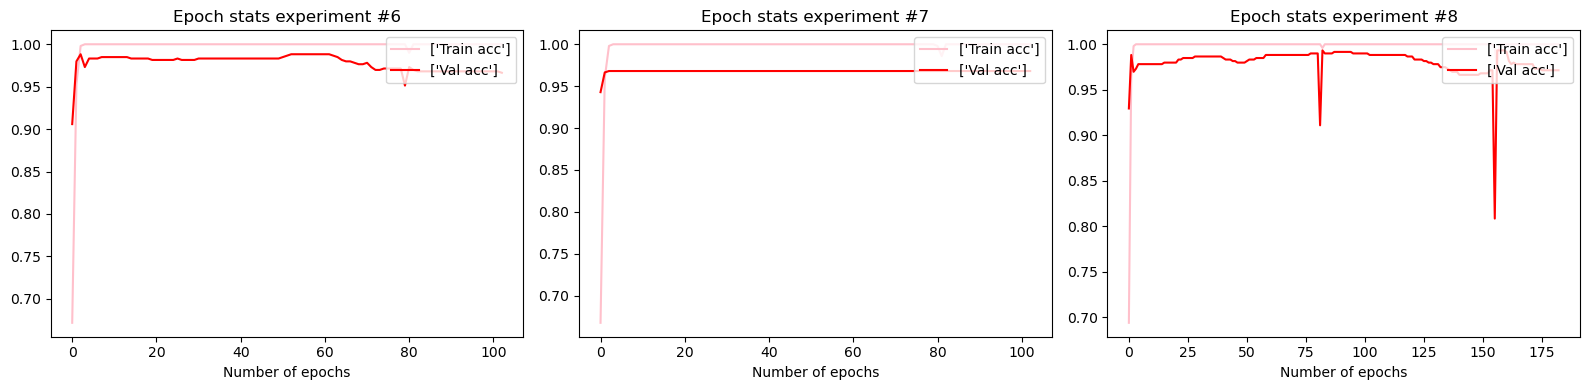

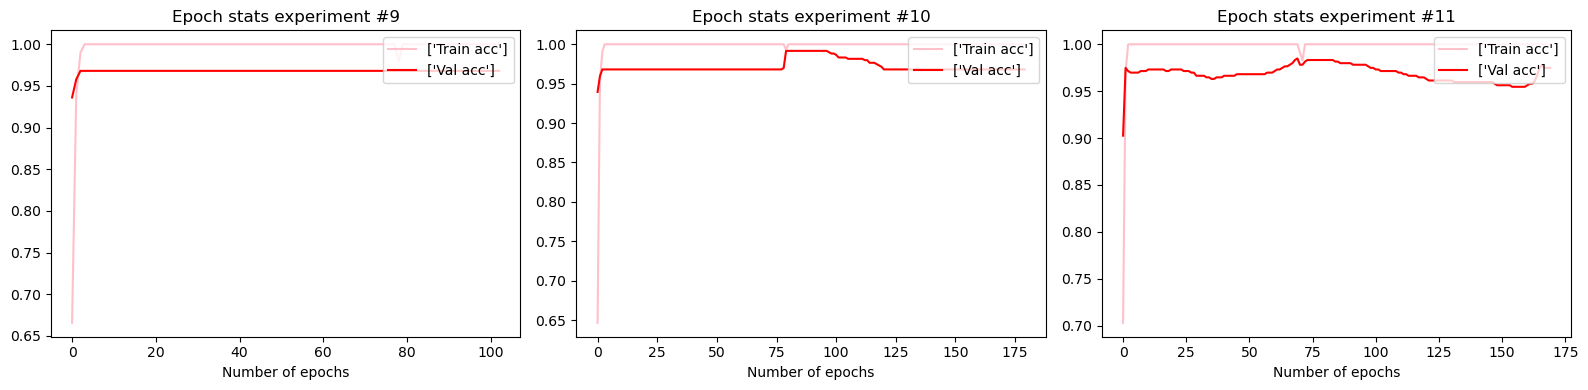

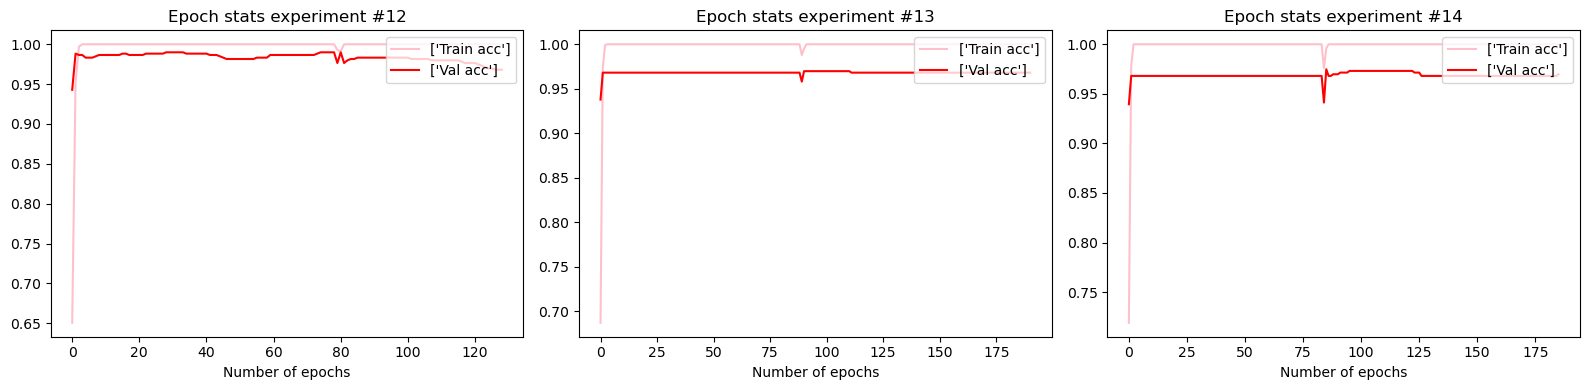

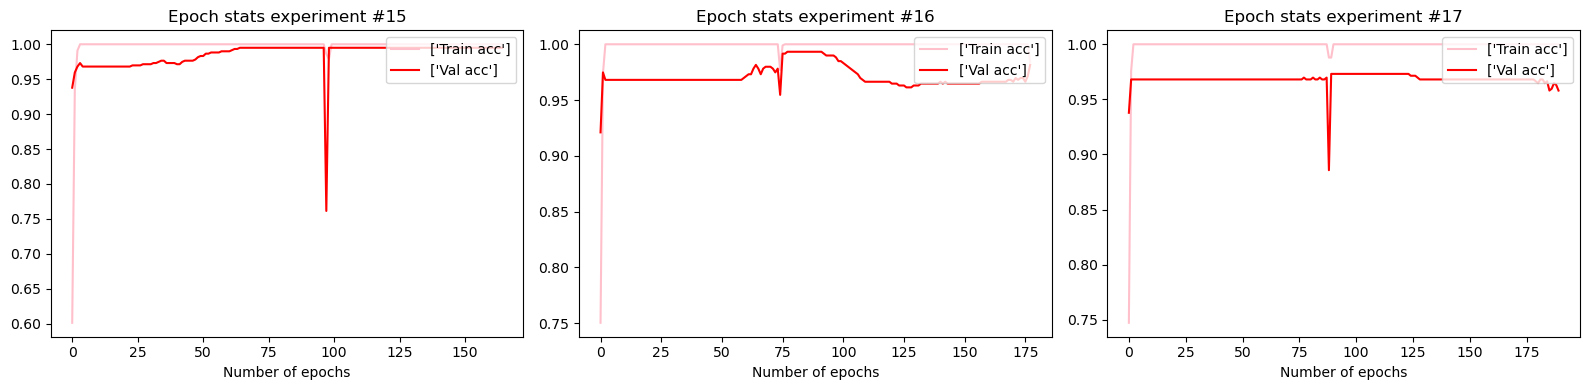

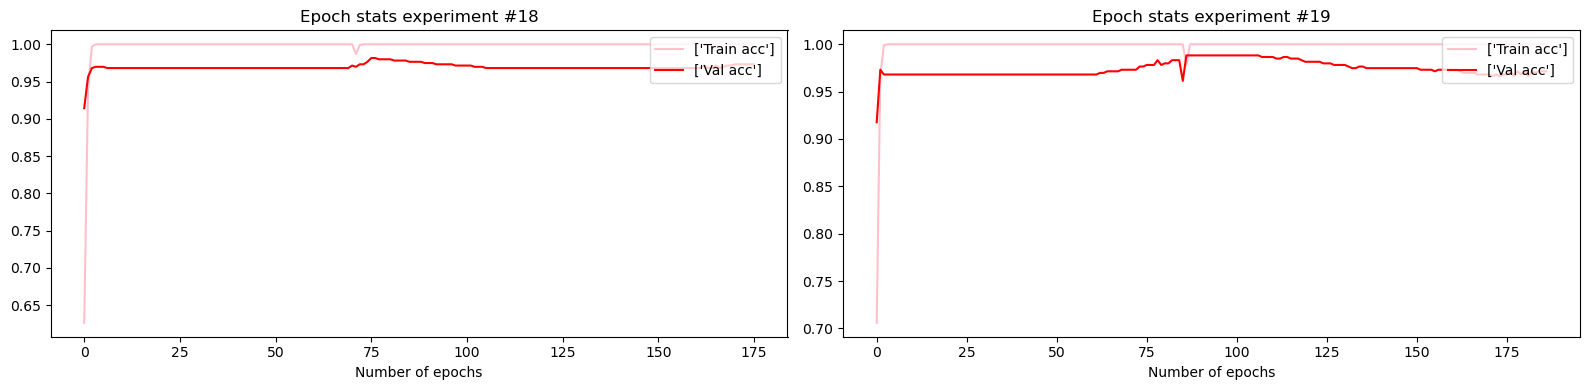

In [38]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

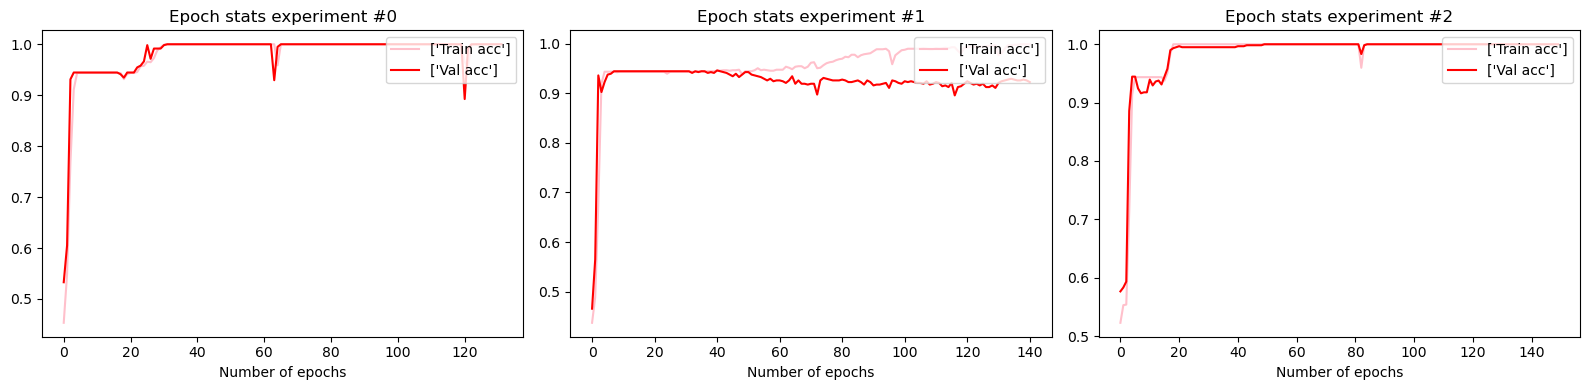

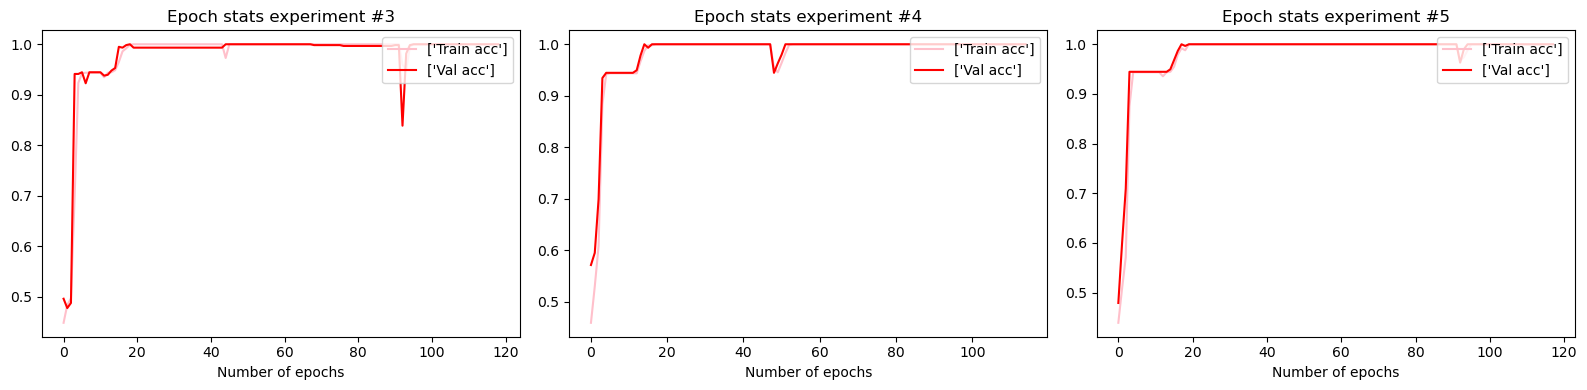

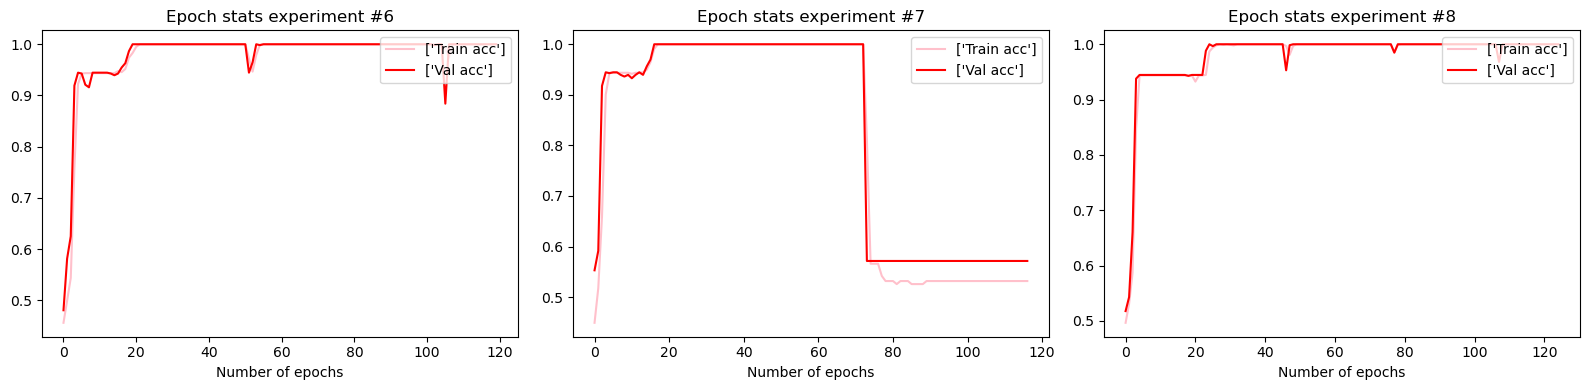

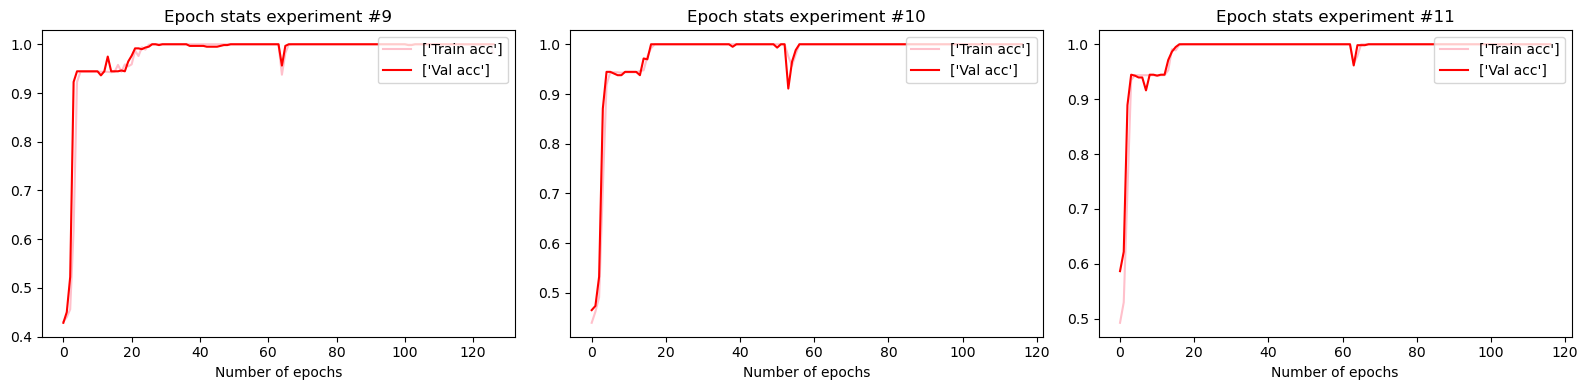

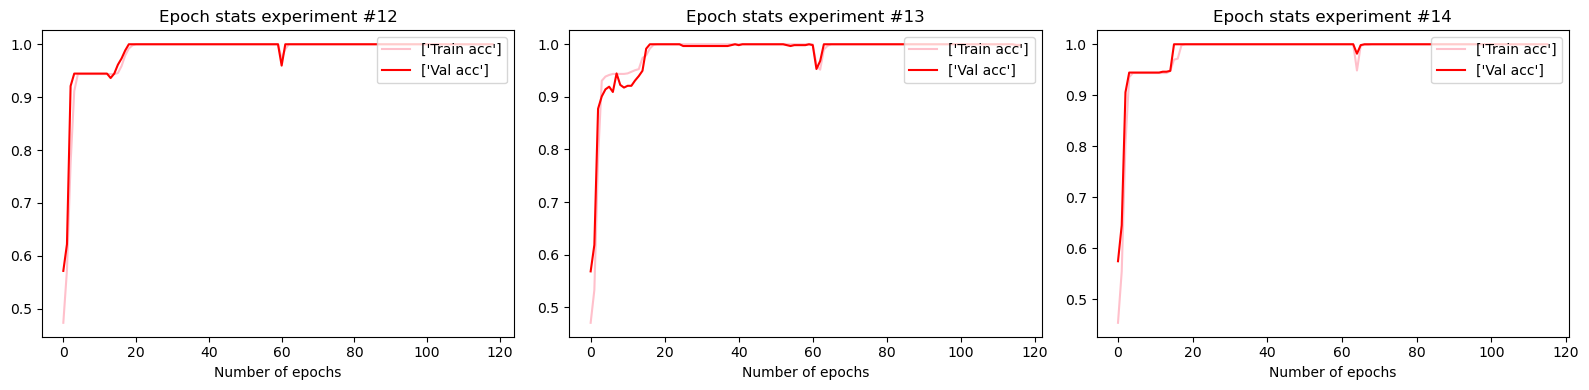

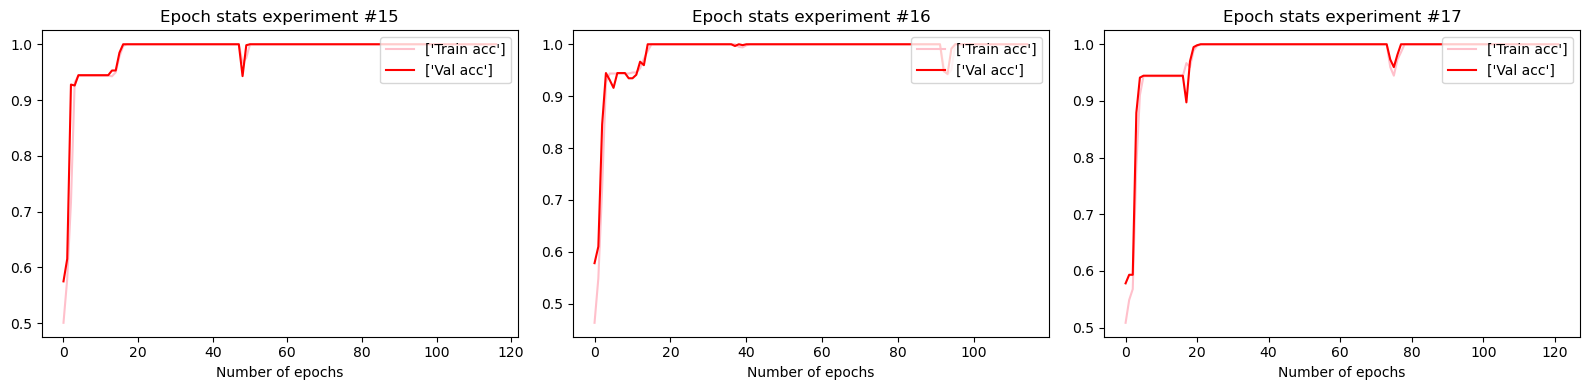

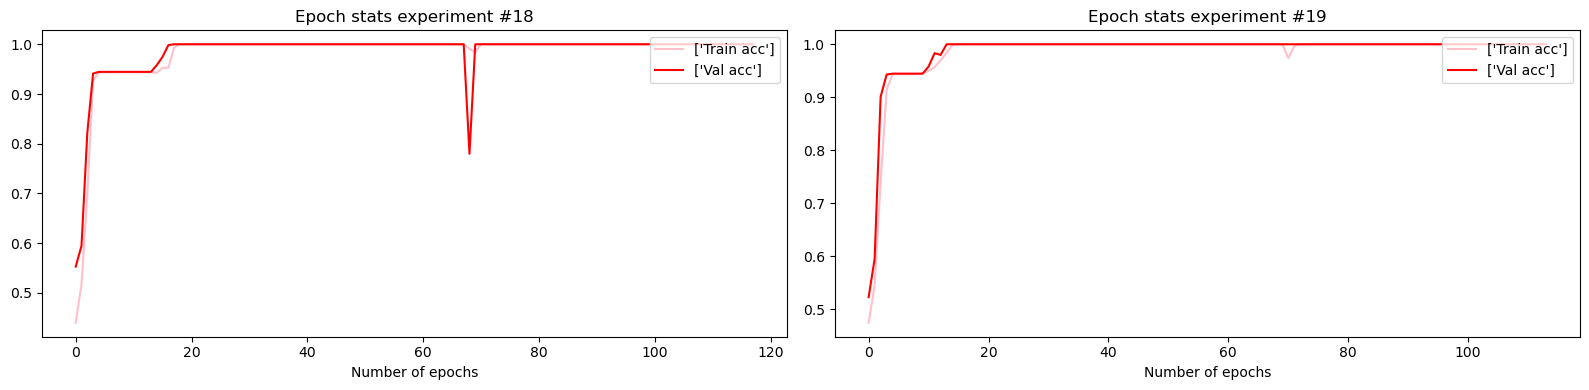

In [39]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

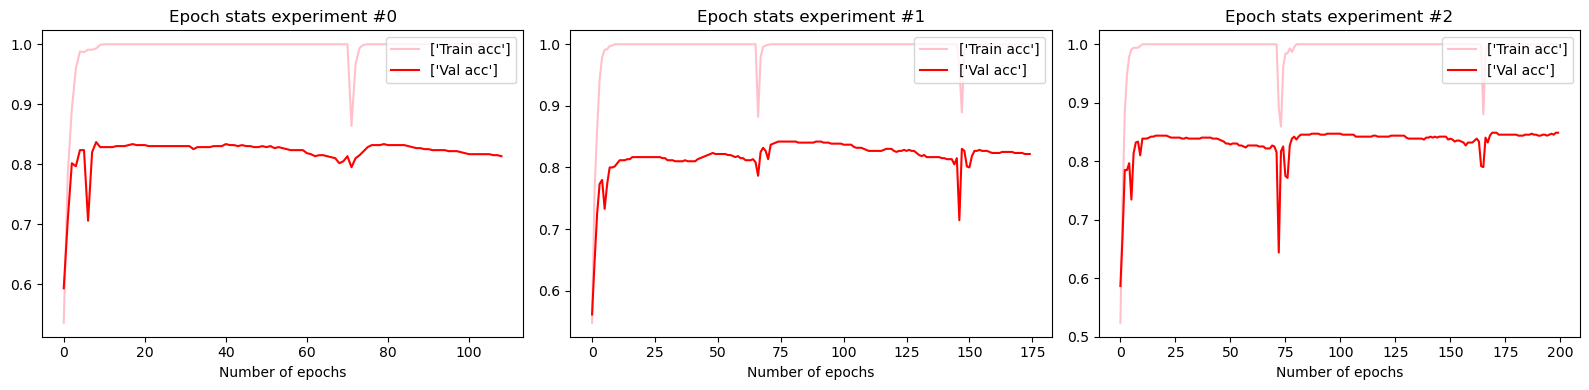

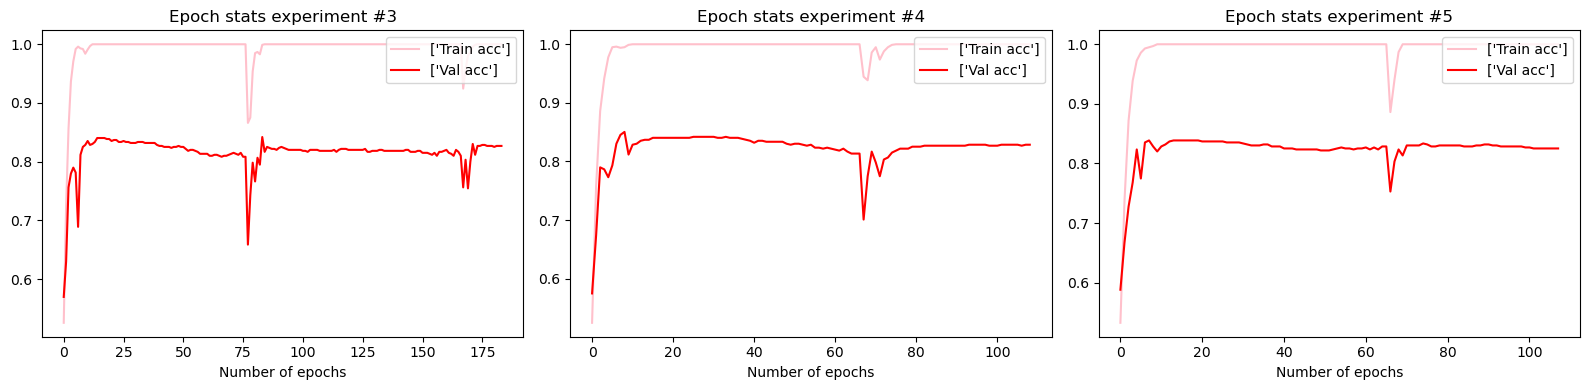

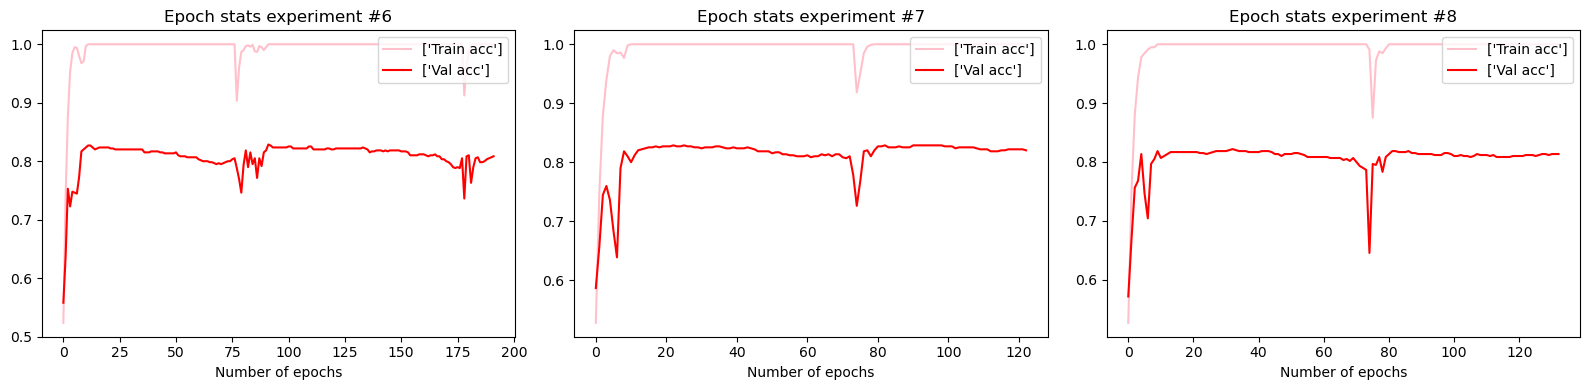

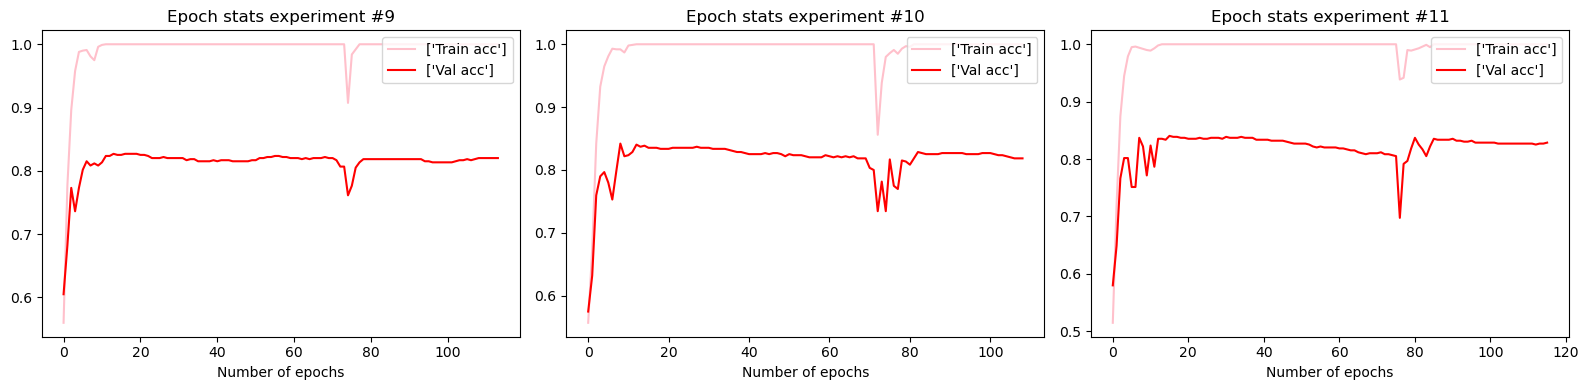

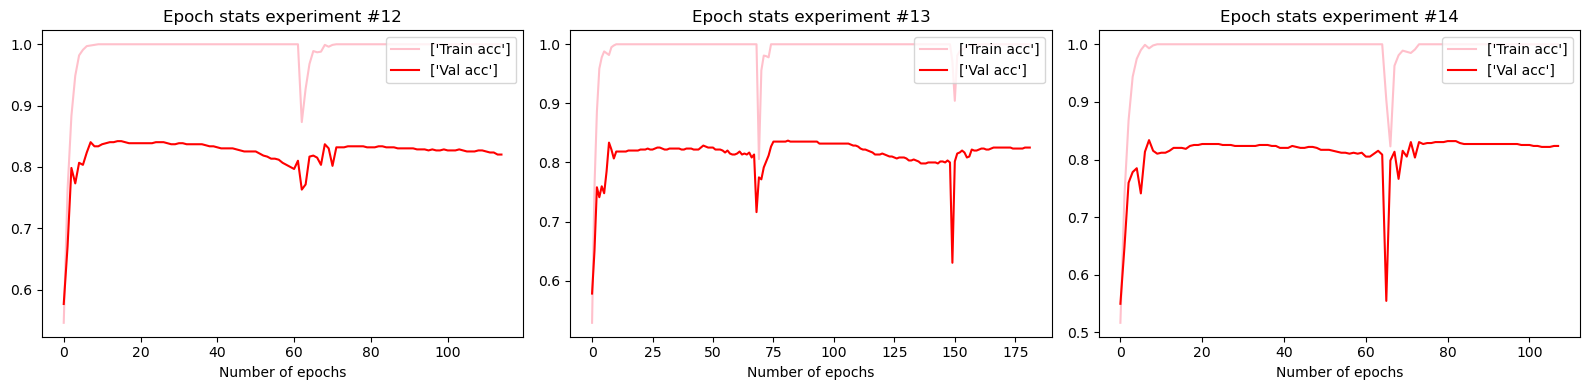

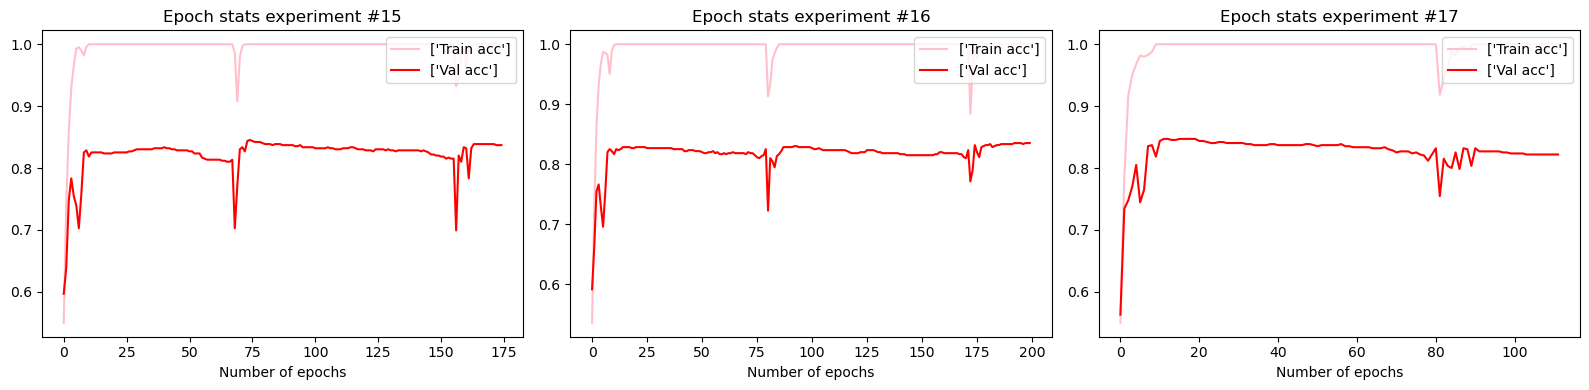

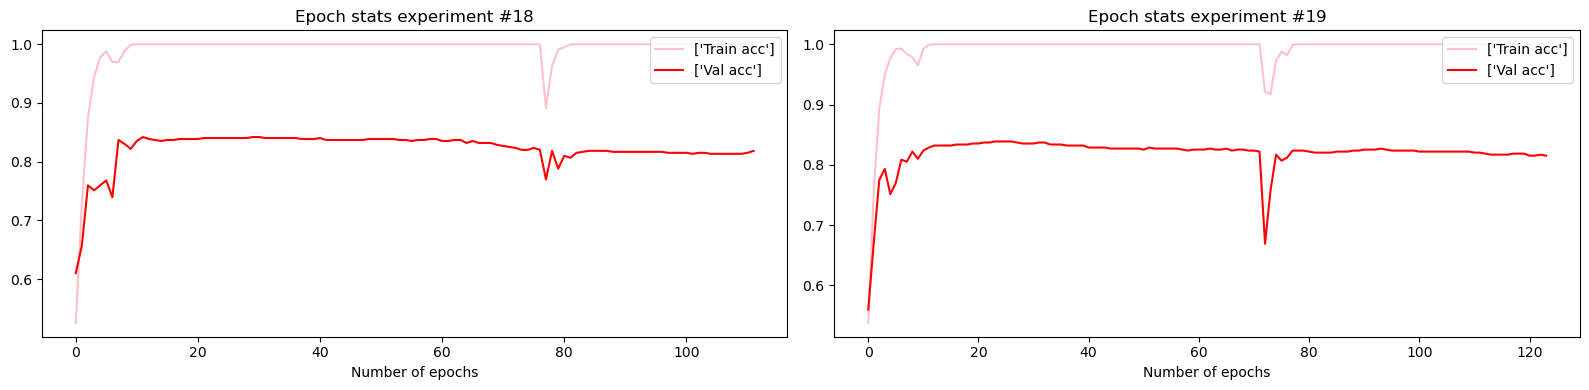

In [40]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

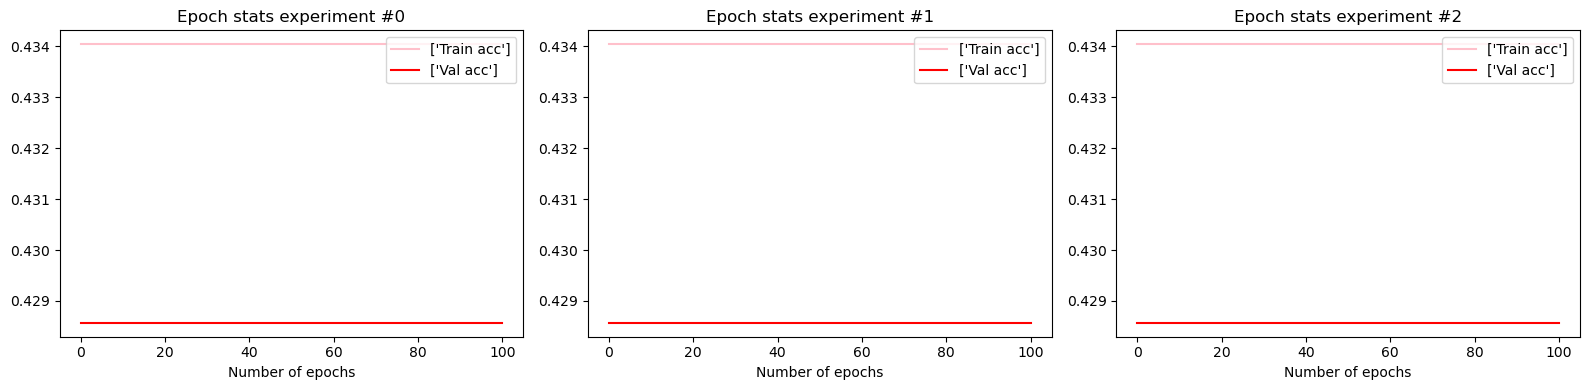

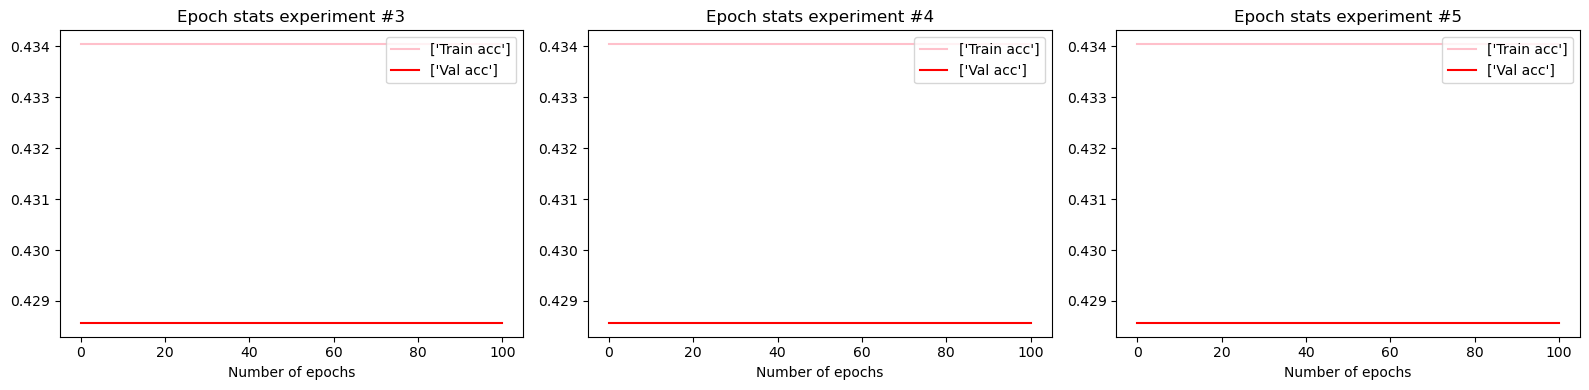

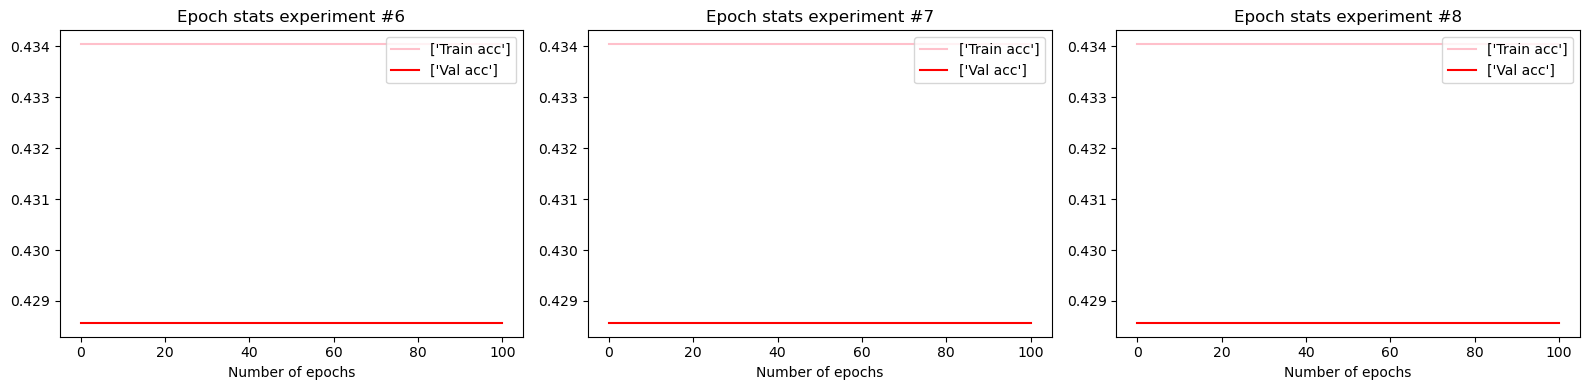

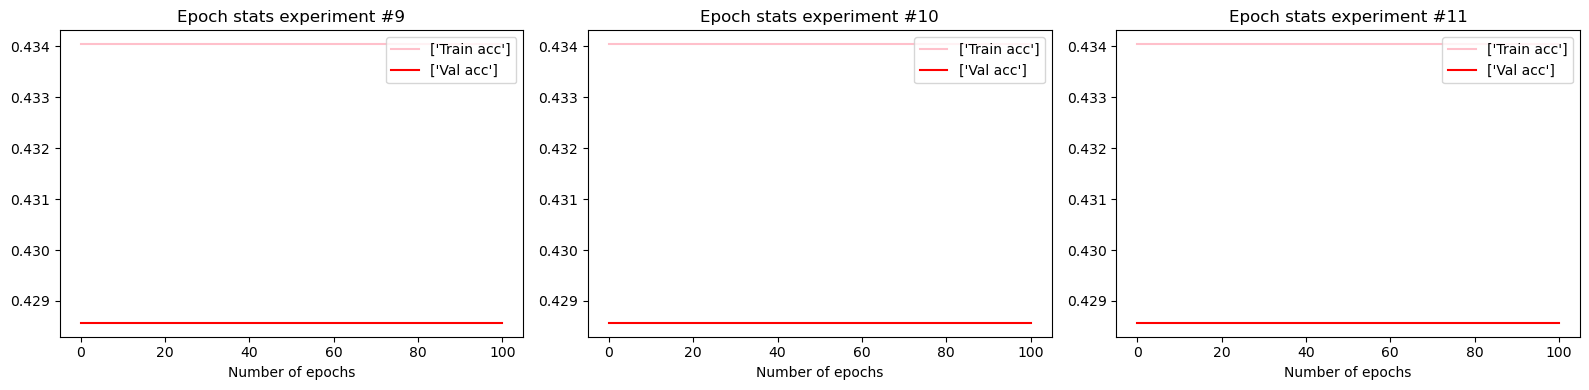

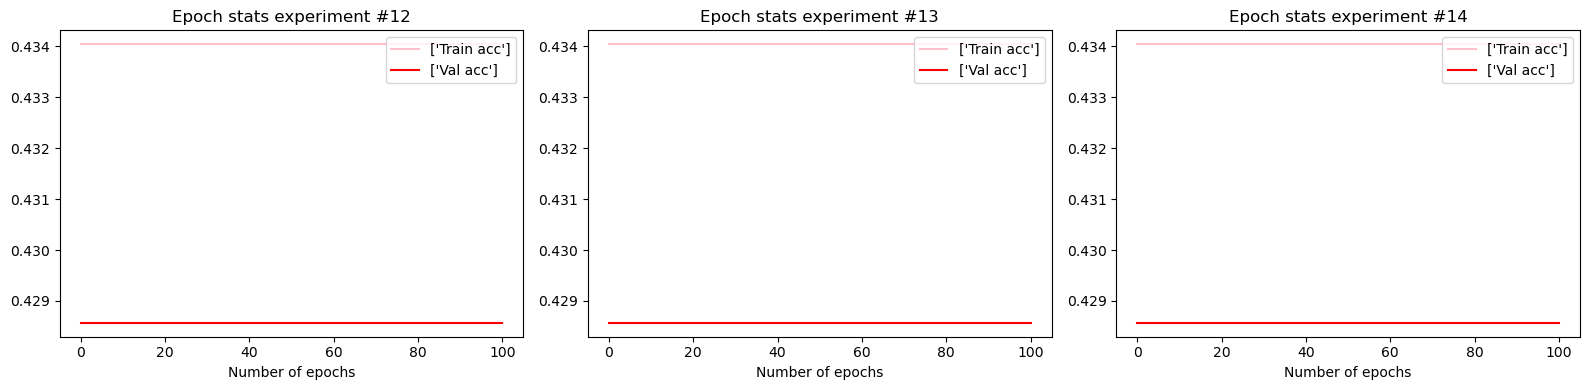

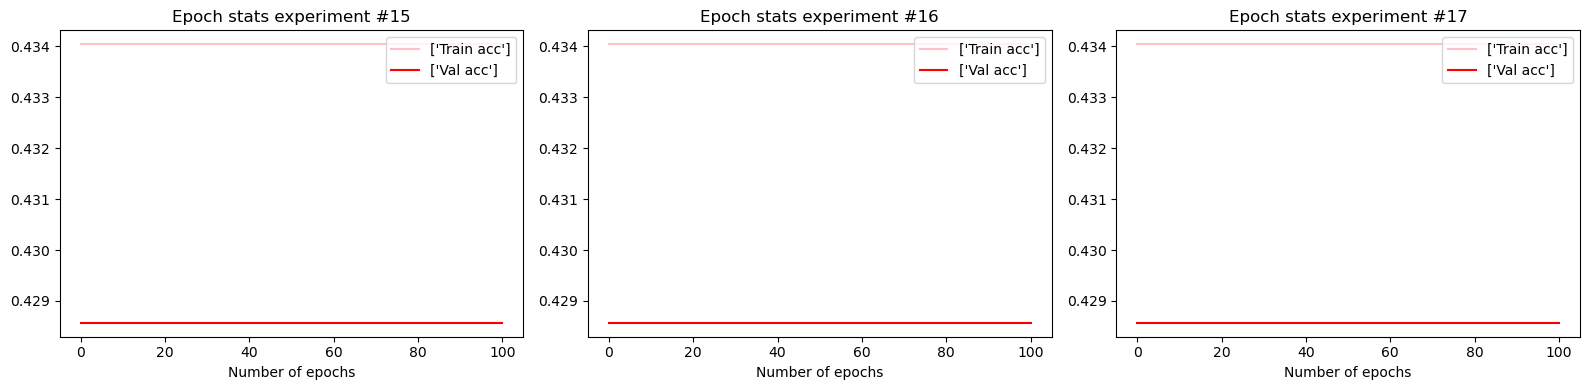

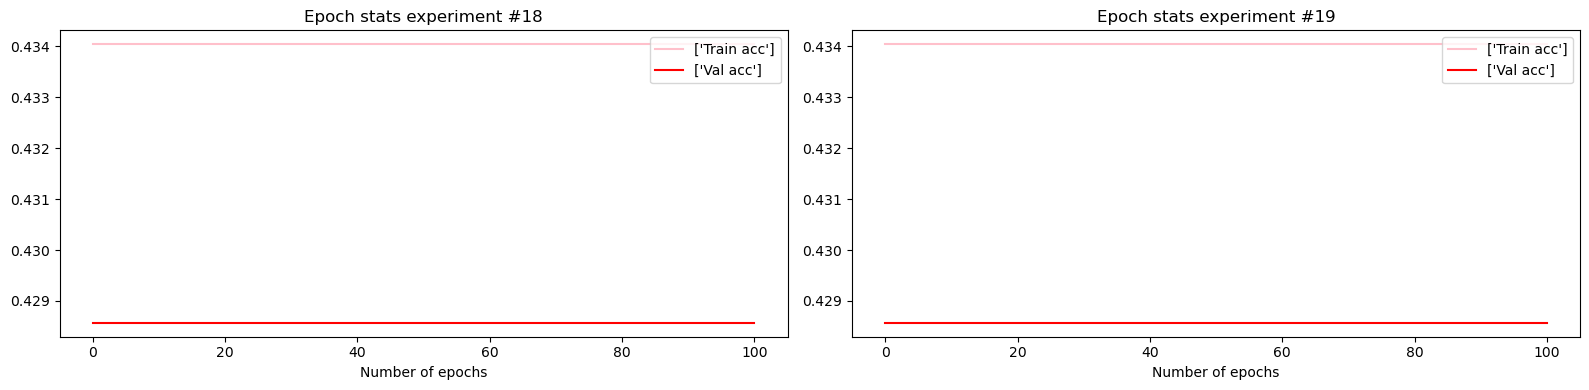

In [41]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

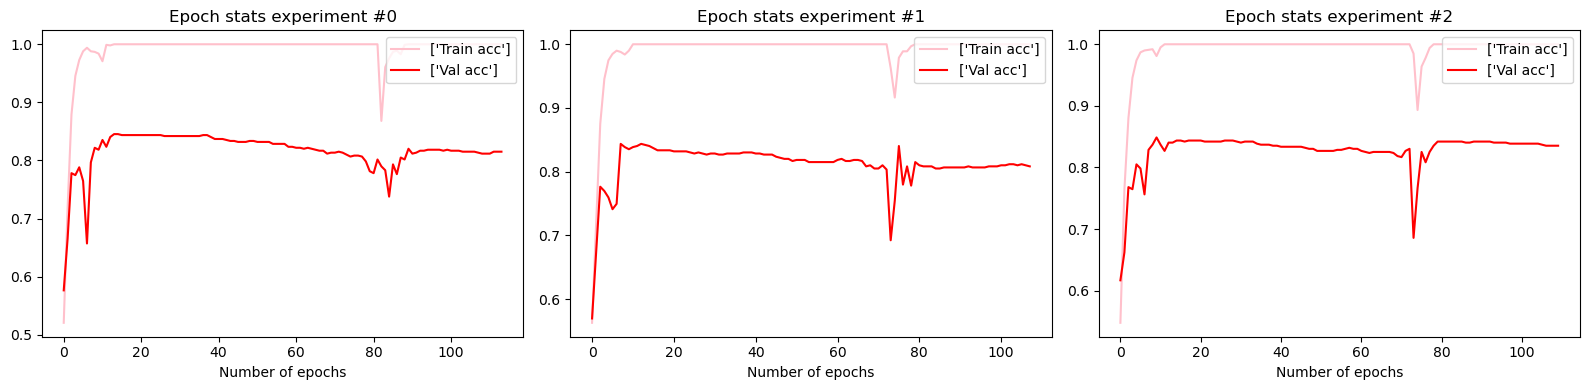

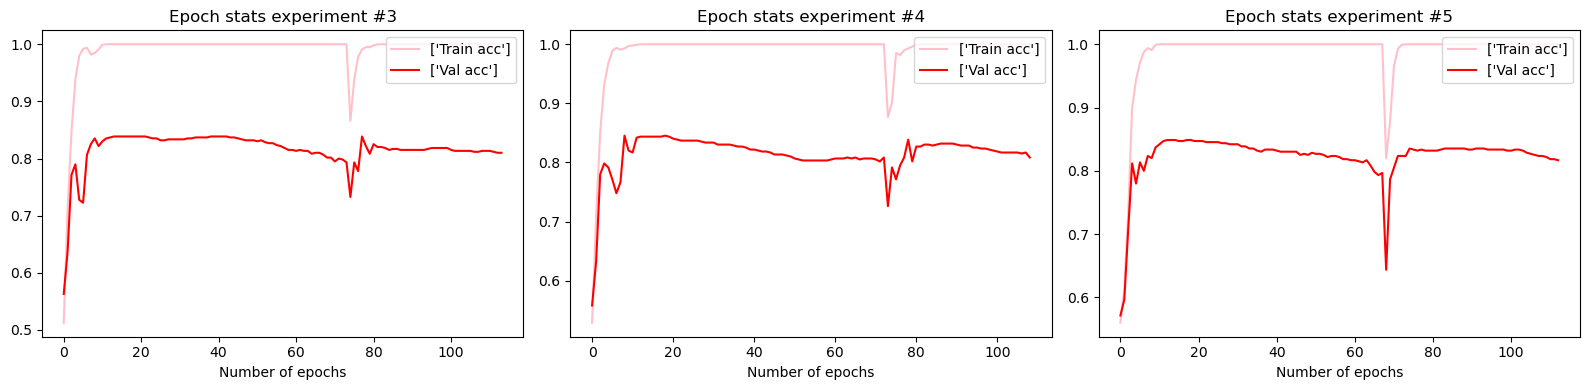

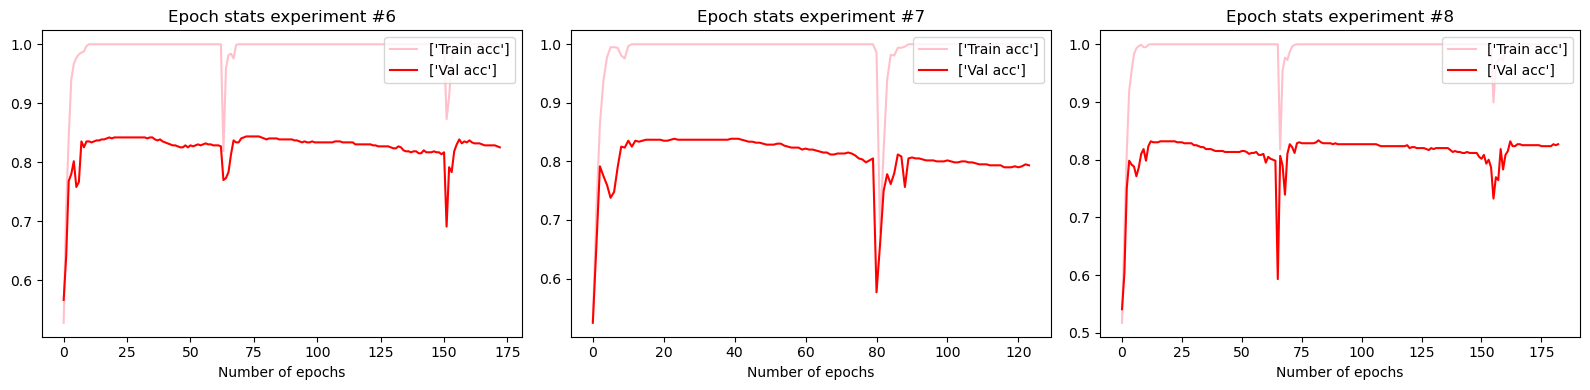

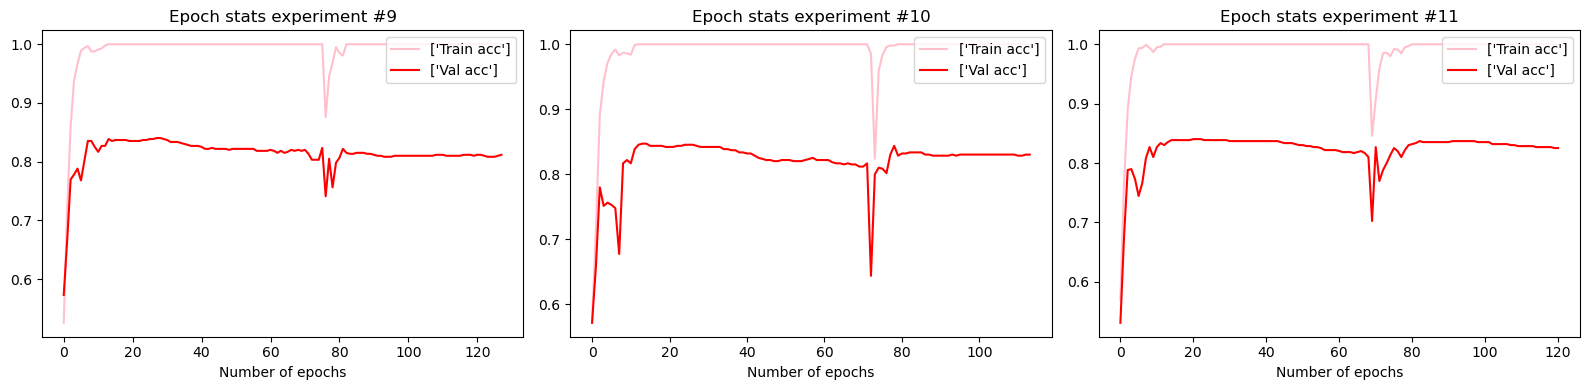

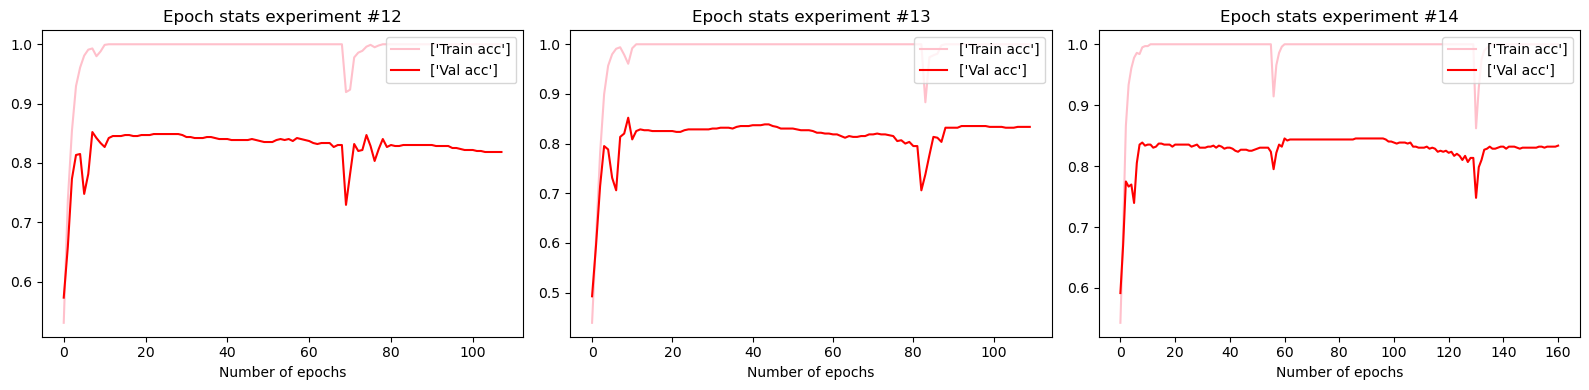

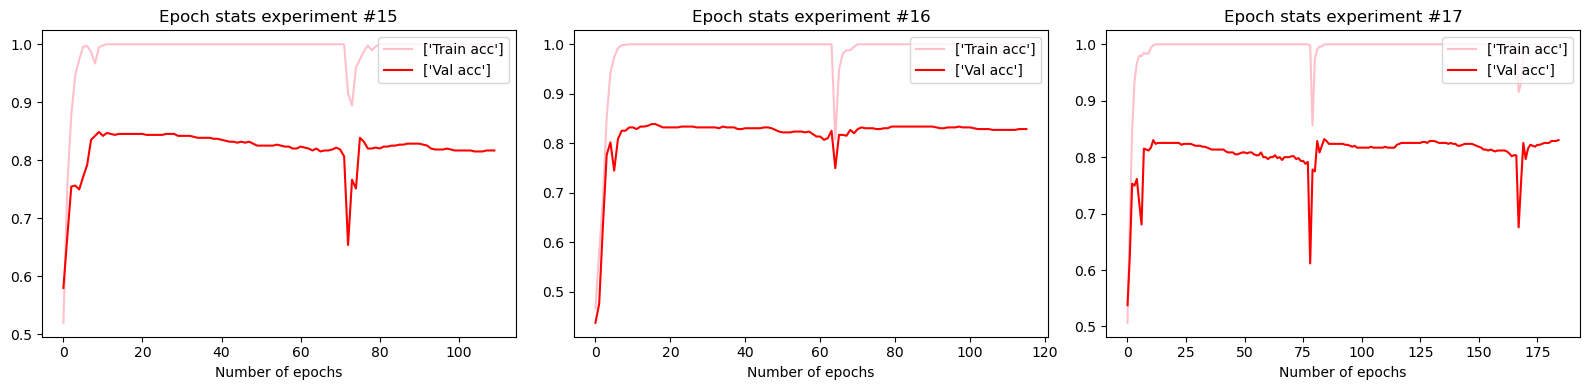

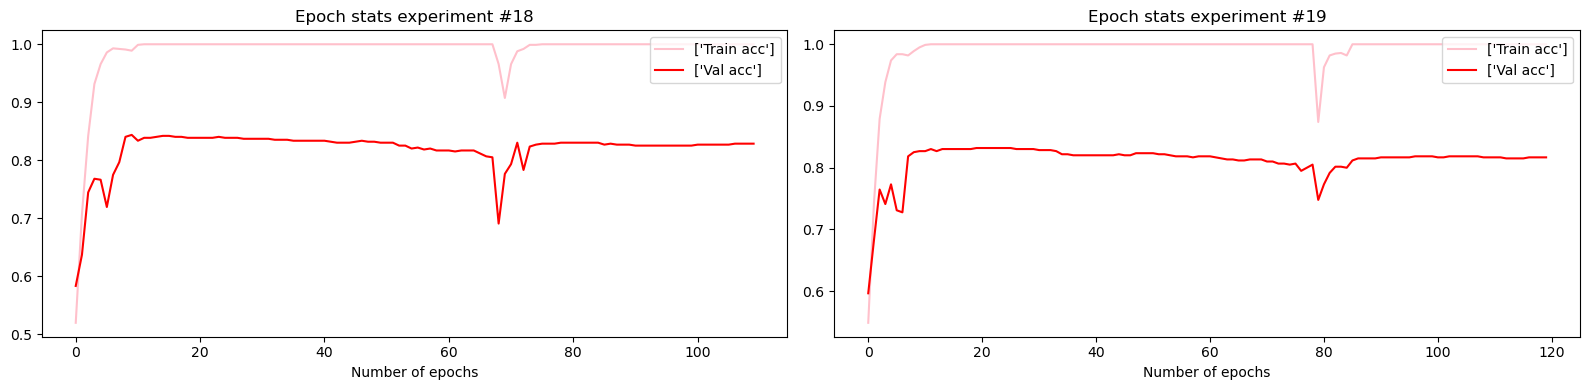

In [42]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [43]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

C:\Users\juand\AppData\Local\Temp\ipykernel_18200\156461178.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_lstm_model.load_state_dict(torch.load('best_LSTM_model_'

<All keys matched successfully>

In [44]:
get_summary_df(["CNN", "LSTM", "DEEPSET", "DEEPSETv2", "FEEDFORWARD"], [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies], [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions], [cnn_recalls, lstm_recalls, deepset_recalls, deepsetv2_recalls, feedforward_recalls], [cnn_f1s, lstm_f1s, deepset_f1s, deepsetv2_f1s, feedforward_f1s])

        Modelo  Accuracy  Precision    Recall  F1-score
0          CNN  0.999160   1.000000  0.998081  0.999039
1         LSTM  1.000000   1.000000  1.000000  1.000000
2      DEEPSET  0.848803   0.844444  0.802303  0.822835
3    DEEPSETv2  0.437631   0.437631  1.000000  0.608823
4  FEEDFORWARD  0.851323   0.817930  0.849328  0.833333


## Top wrong predictions for best performing CNN model

In [45]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

_____wu___,._._. r,,,,_,,_._,_.,_ | label: True | actual prediction: 0.3712136149406433
.__wu,..._.__.__ r,,..______,_.,_ | label: True | actual prediction: 0.4473891258239746
,_.___wu,..,,.,. r,_.,_,,._.._.,, | label: True | actual prediction: 0.54142165184021
wu_..,_,_._.____ r,,_,____._.,,._ | label: True | actual prediction: 0.5803259611129761




## Top wrong predictions for best performing LSTM model

In [46]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

,,,.__,_,._._.uw ,dr,,,,_,_,.,,_, | label: True | actual prediction: 0.5608662962913513
_wu_.,.,,,_,.___ ,,._,,__,,,.,..r | label: True | actual prediction: 0.5644568204879761
,__.,_..._,.wu,_ _,,,_.,,.,.,.,.r | label: True | actual prediction: 0.5716891288757324




## Top wrong predictions for best performing DeepSets V1 model

In [47]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,.,,,,wu.,_...._ ,,,,dr._.._.._.. | label: False | actual prediction: 0.9997990727424622
,.,wu.,.,__.,,_. dr.._.._.,_.,_,_ | label: False | actual prediction: 0.999729335308075
,..wu_,.,,.,_,., _,.__,__dr,._.__ | label: False | actual prediction: 0.9997262358665466
___.__,,._wu__,_ ._,,_._dr___,,,. | label: False | actual prediction: 0.9997054934501648
_____wu_,.,,_.., .___,,,dr.,__,,. | label: False | actual prediction: 0.9996939897537231
__,,_.wu.,_.._., ..,.._dr..,,.._, | label: False | actual prediction: 0.9996932744979858
.,,_wu...,___,_, ,,...dr__.,..,_, | label: False | actual prediction: 0.999659538269043
____.,_,,._,_wu_ ..,__,.,.,_..,dr | label: False | actual prediction: 0.9994366765022278
.,_.,_,wu__,.___ dr_,.__,_,._,,_. | label: False | actual prediction: 0.9994310736656189
,wu.__..,.__.,,, .,,dr.__._,__,,. | label: False | actual prediction: 0.9993560910224915

Top 10 false negatives: 

.,,.____,,..,.wu ._._,._._,_r__._ | label: True | actual pr

## Top wrong predictions for best performing DeepSets V2 model

In [48]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

.,,,,_.,,,_.,,., __,dr..,.._,,._, | label: True | actual prediction: 0.5
__.__._,,_..,_., ._.,__,._,_..r_. | label: True | actual prediction: 0.5
,.___._,_,_,_._w ._,,,dr.,.__.... | label: True | actual prediction: 0.5
.,wu_,_,_,.___,. _.,.,,_.r,,,.,,_ | label: True | actual prediction: 0.5
__.,_,,,,,..__,w .,._,,.r._._,___ | label: True | actual prediction: 0.5
.,,._wu,_..__.., .___....__,,,,,r | label: True | actual prediction: 0.5
,_._......w__,., .__.,..,.,.,.,.r | label: True | actual prediction: 0.5
,,_._._,_,,_,_.. _,_,_,.dr,,,_,__ | label: True | actual prediction: 0.5
,__._,__,.__w,,. .,.._r._._,,__,. | label: True | actual prediction: 0.5
.,.__,....___w,, _,,,,r.._,._,_,. | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [49]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_...,,_.,,_wu... ___dr_,.._...._. | label: False | actual prediction: 0.9997387528419495
.___,..wu___..,_ ._,dr__,__,.,,,_ | label: False | actual prediction: 0.999660849571228
____.,_,,._,_wu_ ..,__,.,.,_..,dr | label: False | actual prediction: 0.9996582269668579
,_.,_.___,,.wu., .,_._.,..___dr_, | label: False | actual prediction: 0.9995664954185486
,wu.__,,,,,.,.,_ _dr.,,.__,._,___ | label: False | actual prediction: 0.9995059967041016
.,,wu,_,__,.,,,_ ...,...__dr.._,, | label: False | actual prediction: 0.9994907379150391
,,_,._,_.,.wu.,_ __,_._.,,..dr.._ | label: False | actual prediction: 0.9994034767150879
_,wu_...,____.,_ _,,dr,,.,,__..__ | label: False | actual prediction: 0.9993233680725098
_____wu_,.,,_.., .___,,,dr.,__,,. | label: False | actual prediction: 0.9990975856781006
.,,.,,,,,__,wu_, _.___,dr,,...,._ | label: False | actual prediction: 0.9988466501235962

Top 10 false negatives: 

..,..uw__.__,._, ,.._,_.r_.,._._, | label: True | actual p

# Saving Notebook State

In [50]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

# Loading Notebook State

In [51]:
import dill
experiment_name = "skip_4"
# dill.load_session('notebook_env_' + experiment_name + '.db')